**Automation of car insurance claim**

As a data scientist who works at Allianz Insurance company, the senior data scientist has asked me to create a model that automatically recognizes car brands. This car brand automation will help complete the insurance claim automation process, as it will be added to the already existing damage analysis, making the insurance claim fully automated.

In this Machine Learning project, I will build an image classification pipeline to identify different car brands.

This will help my company automate the insurance claim process, which will boost the efficiency of the company and reduce delays in insurance claims. The expectations from this automation is better customer experience which will lead to an increase in our customer base and a good retention rate of our existing customers.



In [ ]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import zipfile
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

**Data collection and extraction**
Here, the data has been dowloaded from; https://www.kaggle.com/datasets/kshitij192/cars-image-dataset.
The data is then extracted from the zip file into a folder called "exctrated_folder".

The image data set includes seven different car brands namely; Audi, Hyundai Creta, Mahindra Scorpio, Rolls Royce, Swift, Tata Safari, and Toyota Innova.



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archives.zip to archives.zip


In [ ]:
zip_file_path = "/content/archives.zip"
extract_to_path = "extracted_folder"
os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
     zip_ref.extractall(extract_to_path)
print(f"Data extracted to: {extract_to_path}")

Data extracted to: extracted_folder


In [ ]:
dataset_path = "/content/extracted_folder"
for filename in os.listdir(dataset_path):
    if filename.endswith(".zip"):
        zip_file_path = os.path.join(dataset_path, filename)
        break


        print(zip_file_path)
        print(filename)
        print(dataset_path)
        print(os.listdir(dataset_path))


In [ ]:
dataset_folder = "/content/extracted_folder"
train_dir = os.path.join(dataset_folder, 'train')
test_dir = os.path.join(dataset_folder, 'test')

**Feature Engineering**

Data Augmentation and Transformations

A system for data augmentation is set up by setting up parameters. The parameters are used to create random transformations to the existing training images to increase the data and help the model generalize better.

In [ ]:
batch_size = 32
img_width, img_height = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    'extracted_folder/Cars Dataset/train',
    target_size=(img_width, img_height),
    batch_size = 32
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    'extracted_folder/Cars Dataset/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False
)

print("Classes found in training set: ", train_generator.class_indices)
print("Classes found in test set: ", test_generator.class_indices)


Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.
Classes found in training set:  {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}
Classes found in test set:  {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}


**Data preprocessing and visualization**

Loading and Preprocessing: images were loaded from the training dataset, resized, normalized pixel values, and then they were organized into batches.

Labeling: Labels from the directory structure was used to create categorical labels.

DataFrame Creation: Finally, the loaded images and labels were put into a Pandas dataframe.

In [ ]:
dataset_path = "extracted_folder/Cars Dataset/train"
datagen = ImageDataGenerator(rescale=1./255)
data_flow = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Classes:", data_flow.class_indices)


images, labels = [], []

for batch in data_flow:
    batch_images, batch_labels = batch
    images.extend(batch_images)
    labels.extend(np.argmax(batch_labels, axis=1))
    if len(images) >= data_flow.samples:
        break


idf = pd.DataFrame({
    'Image': images,
    'Label': labels
})


print(idf.head())



Found 3352 images belonging to 7 classes.
Classes: {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}
                                               Image  Label
0  [[[0.5019608, 0.5686275, 0.6392157], [0.501960...      1
1  [[[0.043137256, 0.043137256, 0.043137256], [0....      4
2  [[[0.9215687, 0.92549026, 0.9058824], [0.92156...      0
3  [[[0.9960785, 0.9960785, 0.9960785], [0.996078...      4
4  [[[0.20784315, 0.20784315, 0.21568629], [0.215...      5


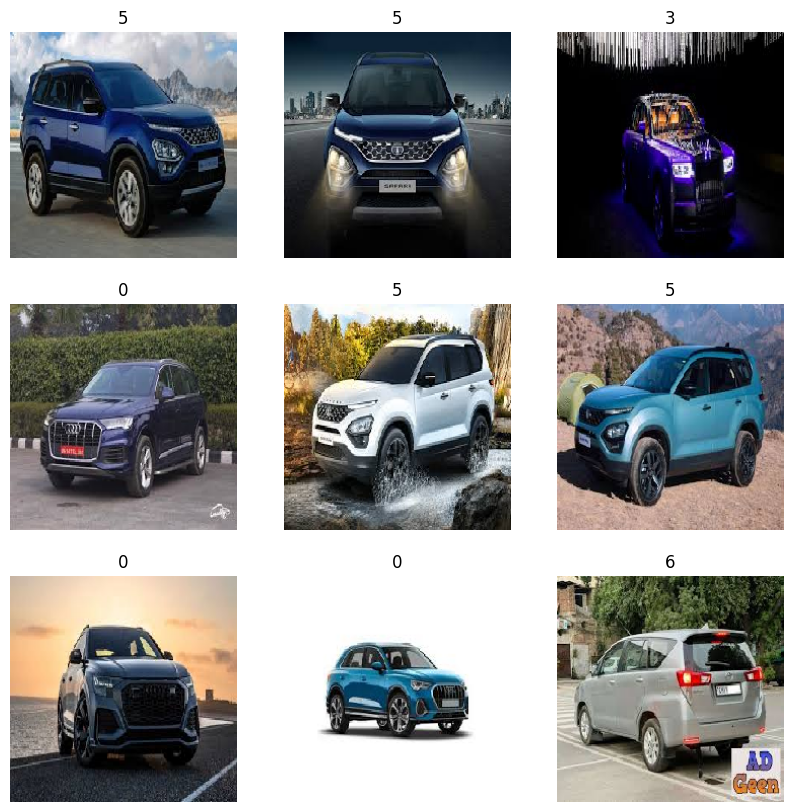

Total samples: 3352
Image shape: (224, 224, 3)


In [ ]:
def visualize_images(batch):
    images, labels = batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()

batch = next(data_flow)
visualize_images(batch)

print(f"Total samples: {data_flow.samples}")
print(f"Image shape: {batch[0][0].shape}")



In [ ]:
def preprocess_images(dataset_path, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

dataset_path = 'extracted_folder/Cars Dataset/train'
train_generator, validation_generator = preprocess_images(dataset_path)

Found 2684 images belonging to 7 classes.
Found 668 images belonging to 7 classes.


**Model Selection and Training**

Create the train, validation and test datasets.

The model of chooice isn this pipeline, CNN is then defined and optimized.

The model is then trained. 17 epochs was settled on because after various runs, the accuracy and val_accuracy begin to decline after the 17th epoch.

In [ ]:
extracted_folder = "extracted_folder"
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "extracted_folder/Cars Dataset/train",
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=42
)


val_dataset = tf.keras.utils.image_dataset_from_directory(
    "extracted_folder/Cars Dataset/train",
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "extracted_folder/Cars Dataset/test",
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

def count_data_items(dataset):
    n = 0
    for _ in dataset:
        n += 1
    return n

train_steps = count_data_items(train_dataset)
val_steps = count_data_items(val_dataset)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=17,
    steps_per_epoch=train_steps,
    validation_steps=val_steps
)

model.save('my_model.keras')

Found 3352 files belonging to 7 classes.
Using 2682 files for training.
Found 3352 files belonging to 7 classes.
Using 670 files for validation.
Found 813 files belonging to 7 classes.
Epoch 1/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.2219 - loss: 162.7357 - val_accuracy: 0.4045 - val_loss: 1.6849
Epoch 2/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.4164 - loss: 1.6118 - val_accuracy: 0.4433 - val_loss: 1.5251
Epoch 4/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.5980 - loss: 1.2398 - val_accuracy: 0.5060 - val_loss: 1.4303
Epoch 6/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.6783 - loss: 0.9937 - val_accuracy: 0.5373 - val_loss: 1.4084
Epoch 8/17
84/84 ━━━━━━━━━

**Model Prediction**

The test dataset is now prepared for prediction by converting the images to numpy arrays, and reshaped for conformity, followed by the predictions. The predictions are then flattened, because they are multidimensional.

In [ ]:
test_images = []
real_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    real_labels.extend(labels.numpy())

test_images = np.array(test_images)
real_labels = np.array(real_labels)

if len(test_images.shape) == 4:
    test_images = test_images.reshape(-1, 224, 224, 3)
try:
    predictions = model.predict(test_images, steps = len(test_images)//16, verbose = 1)
except TypeError:
    predictions = model.predict(x=test_images, )

predictions = predictions.flatten()



50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step


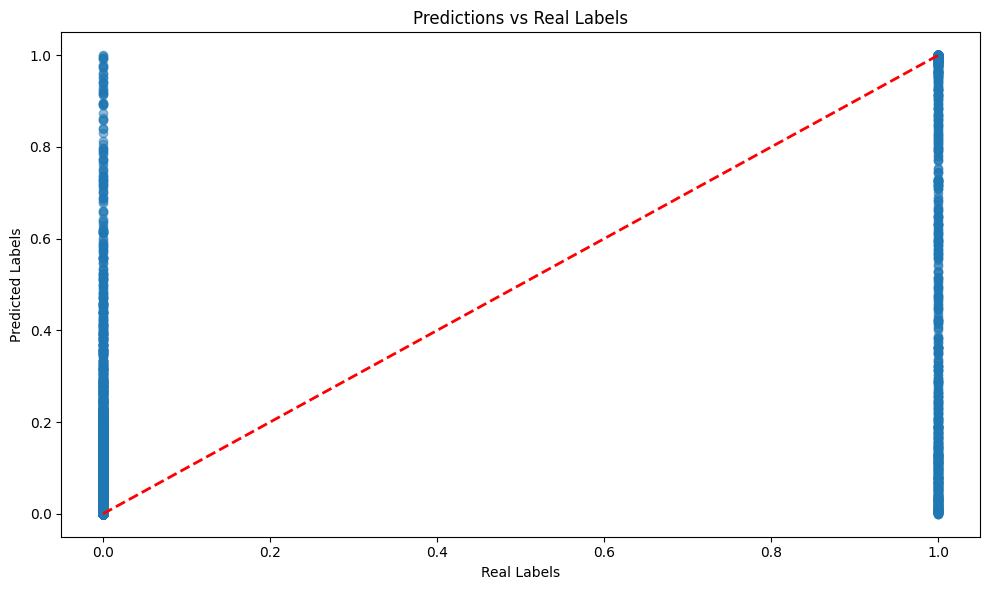

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(real_labels, predictions, alpha=0.5)
plt.plot([real_labels.min(), real_labels.max()],
         [real_labels.min(), real_labels.max()],
         'r--', lw=2)
plt.xlabel("Real Labels")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs Real Labels")
plt.tight_layout()
plt.show()


**Evaluate the model**

The graphs below shows the summary of accuracy and summary of loss

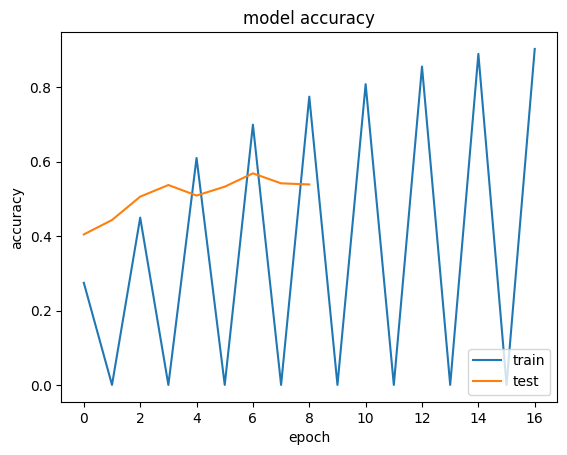

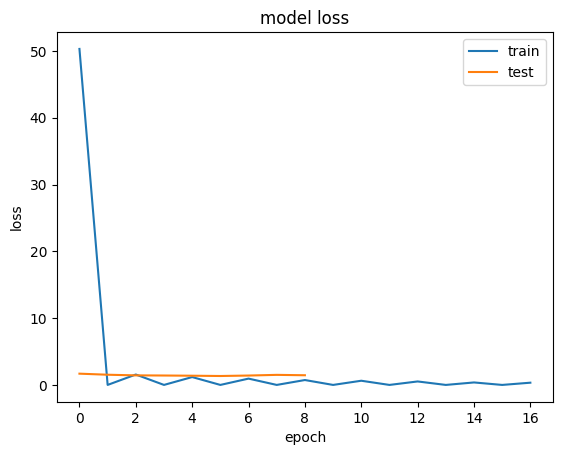

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(test_images, real_labels, verbose=1)
print("Test loss, Test accuracy:", results)

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 928ms/step - accuracy: 0.6575 - loss: 1.1336
Test loss, Test accuracy: [1.2870711088180542, 0.5879458785057068]


Classification Report

In [ ]:
from sklearn.metrics import classification_report
predictions=model.predict(test_images, steps =813)
y_pred = np.argmax(predictions, axis=-1)
y_true = np.argmax(real_labels, axis=-1)
print(classification_report(y_true,y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 912ms/step - accuracy: 0.6575 - loss: 1.1336
Test loss, Test accuracy: [1.2870711088180542, 0.5879458785057068]
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step
              precision    recall  f1-score   support

           0       0.47      0.78      0.58       199
           1       0.71      0.61      0.66        67
           2       0.71      0.36      0.48        75
           3       0.25      0.14      0.18        74
           4       0.52      0.66      0.58       102
           5       0.84      0.63      0.72       106
           6       0.82      0.58      0.68       190

    accuracy                           0.59       813
   macro avg       0.62      0.54      0.55       813
weighted avg       0.63      0.59      0.58       813



**Summary of the car brand detection pipeline**


1.	*Training and Test Performance:*

The final training accuracy is 65.75% with a training loss of 1.1336, while the test accuracy is 58.79% with a test loss of 1.2871.

This shows that the model performed reasonably well during training with a slight decline during the testing.

This presupposes that even though data augmentation techniques were employed in the pipeline to increase the data, the data is still not sufficient to accurately predict different car brands. My recommendation is to use pre-trained models on computers with higher computational power for more robust accuracy results.

2.	*Detailed Breakdown of Metrics per Class*

Class 0: Audi (Precision: 0.47, Recall: 0.78, and F1-Score: 0.58)

This implies that the model does well in identifying actual Audi cars but does that at the expense of labelling many other cars as Audi also, hence the low precision and high recall.

Class 1: Hyundai Creta (Precision: 0.71, Recall: 0.61, and F1-Score: 0.66)

The model fairly balances out its ability to identify actual Hyundai Creta cars with its      ability to predict other cars as Huyndai Creta, hence the F1-Score of 0.66

Class 2: Mahindra Scorpio (Precision: 0.71, Recall: 0.36, and F1-Score: 0.48)

While the model fairly balances out its prediction of Mahindra and the actual Mahindra, it generally performs badly in predicting actual Mahindra cars but performs well at predicting other cars as Mahindra.

Class 3: Rolls Royce (Precision: 0.25, Recall: 0.18, and F1-Score: 0.18)

The model performs at its worst in both predicting actual Rolls Royce and predicting other cars as Rolls Royce.

Class 4:  Swift (Precision: 0.52, Recall: 0.66, and F1-Score: 0.58)

The percentage of prediction of real Swift cars and the percentage of other cars as Swift cars by the model are balanced.

Class 5: Tata Safari (Precision: 0.84, Recall: 0.63, and F1-Score: 0.72)

Tata has the highest precision of all the cars, it seems the model is quick to label other cars as Tata. It also performs a little better than average in predicting actual Tata cars.

Class 6: Toyota Innova (Precision: 0.84, Recall: 0.63, and F1-Score: 0.72)

The model performs quite similarly on Toyota and Tata.

3.	*Key Insights from Overall Metrics:*

•	The model performs inconsistently across different classes
•	Overall accuracy of 59% suggests room for improvement

4. *Recommended Next Steps:*

With different data augmentation parameters to increase the data, and tweaking epoch sizes, the model still leaves room for improvement, hence a pre-trained model on a computer with higher computational power will give the best results.




In [ ]:
#Table showing different tweaks to the model and it's corresponding results.
data = {'Parameters': ['Epoch size=10,Conv2D(16, 32, 64)', 'Epochs =30, Conv2D(16, 32, 64)', 'Epochs =10, Conv2D(32, 64, 128)', 'Epochs =30, Conv2D(32, 64, 128)', 'batch_size=32,Conv2D(16, 32, 64)', 'batch_size=64,Conv2D(32, 64, 128)', 'Conv2D(16, 32, 64), activativation function=sigmoid', 'Conv2D(16, 32, 64),activativation function=softmax', 'Conv2D(32, 64, 128),activativation function=softmax', 'Epochs =17, Conv2D(32, 64, 128)'],
        'Test_loss': [1.4079, 1.3054, 1.3075, 1.4033, 1.5003, 1.4509, 1.6090, 1.5880, 1.4020, 1.2870],
        'Test_accuracy': [0.51, 0.54, 0.54, 0.52, 0.51, 0.51, 0.52, 0.50, 0.51, 0.58],
        'Overall_accuracy': [0.51, 0.54, 0.55, 0.52, 0.52, 0.51, 0.53, 0.51, 0.51, 0.59 ],
        }
df = pd.DataFrame(data)

# Display the DataFrame as a table
display(df)

,Parameters,Test_loss,Test_accuracy,Overall_accuracy
0,"Epoch size=10,Conv2D(16, 32, 64)",1.4079,0.51,0.51
1,"Epochs =30, Conv2D(16, 32, 64)",1.3054,0.54,0.54
2,"Epochs =10, Conv2D(32, 64, 128)",1.3075,0.54,0.55
3,"Epochs =30, Conv2D(32, 64, 128)",1.4033,0.52,0.52
4,"batch_size=32,Conv2D(16, 32, 64)",1.5003,0.51,0.52
5,"batch_size=64,Conv2D(32, 64, 128)",1.4509,0.51,0.51
6,"Conv2D(16, 32, 64), activativation function=si...",1.6090,0.52,0.53
7,"Conv2D(16, 32, 64),activativation function=sof...",1.5880,0.50,0.51
8,"Conv2D(32, 64, 128),activativation function=so...",1.4020,0.51,0.51
9,"Epochs =17, Conv2D(32, 64, 128)",1.2870,0.58,0.59
